# Questions enoncés : 

* 20 or 50 ? 
* Price average ? Moving AVERAGE ? 

# Industrial economy

## Aim of work : 
* Compare classic Cournot oligopoly equilibrium with results obtained with a simple iterative process where players evolve their optimal strategies
* Different market concentration [monopoly, duopoly, triopoly]
* One sided auction : 
    1. Each indiv. firm selects its outpout
    2. Simultaneous offer of quantities to the market
    3. Compute a uniform price for all of these quantities
    4. Each indiv. compute its profits
    5. Thanks to profit each indiv. submits new quanity
> Repeat

### Market rules
$$P(Q) = 600 - Q $$
$$Q = \sum q_i $$
* All players are homogeneous hence : cost = 0

### Production design
* Random pick between 
*With n : number of firms*
$$Q \in ]0;5*IntegePart(120/n]$$
* Produce between 0 and a max capacity 
* All firms have identical production
* Set of individual bid is discrete : 
    * Can only take values such as 5-units increments : 
    * We have a bid index link to a quantity produced
    * 5,10 ... K-5, K with K=5
    * Set of S 
    * Uniform probability
    
![Auction_table](table_auction.png)



## Functions

#### Reinforcement

![reinforcement](reinforcement.png)

## Import packages

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numba import njit,prange

## Data structure

### We are going to have : 
* With : p = periods 
* With : n = number of firms
* With : s = number of bids possibilities - depending of E(120/n)

#### A)  Bid matrix :
* A matrix : p rows & n columns (p,n)
    * bid(p,n) = Bid of firm n at period p

#### B)  Profit matrix:
* A matrix : p rows & n columns (p,n)
    * profit(p,n) = Profit of firm n at period p


#### C)  Propensions matrix:
* A matrix : s rows & n columns (s,n)
    * prop(s,n) = Propensions of bid s for firm n


## Build framework

![consignes](consignes.png)


In [3]:
@njit
def propensions_reinforcement_part1(s_bid,propension,profit,lambda_,delta,gamma):
    """Reinforcing s_bid -- s_bid in 1..S : 
    Args :
        s_bid (int): s_bid value
        propension (float) : propension of s_bid
        profit (float) : profit at period p
        lambda_ (int) : s_bid picked at period p
        gamma (float) : forget rate 
        delta (floot) : propension increaser
    Returns:
        new_propension (float): reinforced propension
        """
    # First step : comparison between previously picked s_bid 
    # and current s_bid
    # Tricking thing on the bound
    if s_bid==lambda_:
        new_propension = (1-gamma)*propension+profit
    elif s_bid == lambda_-1 or s_bid == lambda_ +1:
        new_propension = (1-gamma)*propension+profit*(1-delta)
    else:
        new_propension = (1-gamma)*propension
    return new_propension

In [5]:
propensions_reinforcement_part1(s_bid=1,propension=2,profit=10,
                                lambda_=1,delta=0.5,gamma=0.5) # Compile numba function

11.0

In [6]:
@njit
def rand_choice_nb(arr, prob):
    """Alternative for np.random.choice 
       suitable for numba"""
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

In [7]:
rand_choice_nb(np.array([0,1]), np.array([.5,.5])) # Compile numba function

0

In [8]:
@njit(parallel=False) # Using njit refers to numba, a compiler in python, which convert python to C equivalent.
# By compiling the functions with function we can increase dramatically the speed
def numba_cournot_framework(n_firms, p_periods,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    """Cournot framework - Simulate market situations
    Args :
        n_firms (int): Number of firms : n_firms>=1 
        p_periods (int): Number of simulation periods
        initial_propension (float) : initial_propension for each value
        mu (float) : extinction in finite time
        gamma (float) : gradual forgetting 
        delta (float) : persistent local experimentation
        total_demand (int): total demand of market
    Returns : 
        bid_mat (np.matrix): Matrix of bid for each firm at each period
        profit_mat (np.matrix): Matrix of profit for each firm at each period
        prop_mat (np.matrix) : Propension matrix for each bid for each firm for each period
        price_vec (np.array) : Market price for each period"""
    
    s_discrete = int((120/n_firms)//1) #Max of allowable bids - Integer part of 120/n
    bid_mat = np.zeros((p_periods,n_firms)) # Bid matrix : (p_periods,n_firms)
    profit_mat = np.zeros((p_periods,n_firms)) # Profit matrix : (p_periods,n_firms)
    prop_mat = np.zeros((s_discrete,n_firms,p_periods)) # Propensions matrix : (S,n_firms,p_periods)
    prop_mat[:,:,0] = initial_propension # Initialize propension - setting up for first iteration
    secrete_bids = np.arange(1,s_discrete+1) #Set of allowable bids
    bid_possibilities = np.arange(1,s_discrete+1)*5 #Bids possibities (*5) [5,10 ...5*S]
    price_vec = np.zeros(p_periods) # Price vector : (p_periods)
    
    for period in range(p_periods):
        #For each period we compute the propbability matrix based on propension vector
        prob_mat = prop_mat[:,:,period]/np.sum(prop_mat[:,:,period],axis=0) #probability matrix
        for firm in prange(n_firms):
            ### Across all firms
            # We determine for each firm the bid
            # rand_choice_nb(vec, prob) returns a value in array based on a probability vector
            # prob[:,firm] : probability for each bid for a given firm
            bid_pick = rand_choice_nb(bid_possibilities, prob=prob_mat[:,firm])
            bid_mat[period,firm] = bid_pick # We set bid picked for the firm at this period
        # Once bid are made we can compute price
        market_price = total_demand-np.sum(bid_mat[period,:]) # P(Q)=600-SUM(Qi)
        price_vec[period] = market_price # We save the price of this period
        profit_mat[period,:] = market_price*bid_mat[period,:] # We compute the profit (no cost of prod.)
        # Need to recompute propensions for next iterations
        for firm in range(n_firms):
            lambda_ = bid_mat[period,firm]/5 #Get lambda of the firm i.e the bid picked at this period
            profit = profit_mat[period,firm] #Retrieve this associated profit
            # For each allowable bid in 1..S 
            for s_bid in range(s_discrete):
                # Loop bound  reinforcement
                #########  Part 1 of reinforcement #######################:
                # Current propension for this period
                propension = prop_mat[s_bid,firm,period]
                # Warning : s_bid+1 because python starts at 0
                # We resort to a function that recalculates propension given multiple input
                new_propension = propensions_reinforcement_part1(s_bid+1,propension,
                                                                 profit,lambda_,delta,gamma)
                # Set propension for next period
                if period + 1 < p_periods:
                    ## Do not outbound the number of periods
                    prop_mat[s_bid,firm,period+1] = new_propension # Set new propension
            ############## Part 2 : adjust regarding mu #################
            if period + 1 < p_periods:
                ## Do not outbound the number of periods
                propension_vec = prop_mat[:,firm,period+1] # Extract propension vector
                # We look at the new propension for next period, and before going further
                # we adjust propension regarding mu
                propension_vec_mu_filter = (propension_vec/np.sum(propension_vec))>mu # rs/sum(rs)>mu
                # By multipling like that we implement the indicator function
                prop_mat[:,firm,period+1] = propension_vec*propension_vec_mu_filter # (0,1,0,0)*(propension)
                # We can go to the next period !
    return (bid_mat,profit_mat,prop_mat,prob_mat,price_vec)

### Erreur : matrice propension & comparaison avec lambda

In [9]:
def plot_results(n_firm,price_vec,color,avg=False,window=20):
    dic = {1:"Monopoly",2:"Duopoly",3:"Triopoly"}
    if n_firm in dic:
            t = dic[n_firm]
    else:
        t = f'{n_firm}-opoly'
    plt.figure(figsize=(10,5))
    plt.xlabel("P periods")
    plt.ylabel("Market price")
    if avg:
        price_vec = pd.Series(price_vec).rolling(window).mean()
        plt.plot(range(len(price_vec)),price_vec,c=color)
        
        plt.title(f"Simulation of market price with a {t} - {window} Moving Average")
    else:
        plt.plot(range(len(price_vec)),price_vec,c=color)
        plt.title(f"Simulation of market price with a {t}")
    plt.axhline(600/(n_firm+1),color="green",label="Theoretical value")
    plt.legend()
    plt.show()

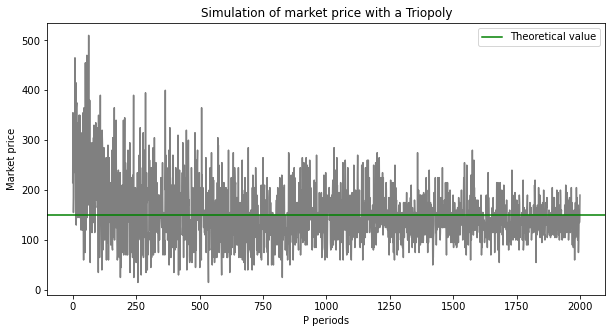

CPU times: user 215 ms, sys: 28.3 ms, total: 243 ms
Wall time: 103 ms


In [49]:
%%time
n_firm = 3
bid_mat,profit_mat,prop_mat,prob_mat,price_vec = numba_cournot_framework(n_firms =n_firm,p_periods =2000,
                                                                        delta=0.3,mu=0.002,gamma=0.01)
plot_results(n_firm,price_vec,color="gray",avg=False,window=2000)

## Multi cournot

In [67]:
@njit(parallel=True)
def multi_cournot_mult_struct(n_struct,p_periods,n_sample,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    prices = np.zeros((2000,n_struct,n_sample))
    for n_firm in prange(n_struct):
        for sample in prange(n_sample):
                price_vec = numba_cournot_framework(n_firms = n_firm+1,p_periods =p_periods)[-1]
                ### Need to compute MA 200
                #series_price_vec = pd.Series(price_vec).rolling(200).mean()
                prices[:,n_firm,sample] = price_vec[:]
    return prices
@njit(parallel=False)
def multi_cournot_one_struct(struct,p_periods,n_sample,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    prices = np.zeros((2000,n_sample))
    for sample in prange(n_sample):
        price_vec = numba_cournot_framework(n_firms = struct,p_periods =p_periods)[-1]
        ### Need to compute MA 200
        #series_price_vec = pd.Series(price_vec).rolling(200).mean()
        prices[:,sample] = price_vec[:]
    return prices

In [210]:
def plot_multiple(prices,n_firm,color,n_sample,window=200):
    dic = {1:"Monopoly",2:"Duopoly",3:"Triopoly"}
    if n_firm in dic:
            t = dic[n_firm]
    else:
        t = f'{n_firm}-opoly'
    plt.figure(figsize=(10,5))
    plt.xlabel("P periods")
    plt.ylabel("Market price")  
    c = pd.DataFrame(prices).rolling(window).mean().T
    for i in range(len(c)):
        plt.plot(range(c.shape[1]),c.iloc[i,:],color=color)
        
    plt.axhline(600/(n_firm+1),color="green",label="Theoretical value")
    plt.title(f"Simulation of market price with a {t} - {window} Moving Average - {len(c)} sample")
    plt.legend()
    plt.show()
    # Histogram view
    last_price=c.iloc[:,1999]
    plt.figure(figsize=(10,5))
    sns.histplot(last_price,color=color,kde=True,stat="percent")
    plt.xlabel(f"Moving average price at period 2000 with {n_sample} sample")
    mean = last_price.mean()
    sigma = last_price.std()
    plt.axvline((600)/(n_firm+1),color="green",linewidth=5,linestyle="--",label="Theoretical value")
    plt.axvline(mean,color="k",linewidth=5,linestyle="--",label="Mean of simulated price")

    desc = fr'\mu={round(mean,2)}\||\sigma={round(sigma,2)}'
    max_y=100
    max_x=np.histogram(last_price)[1].max()
    plt.text(0.85*max_x,0.04*max_y,f'${desc}$',size=20,color="black")
    plt.legend()
    plt.show()
    return last_price

In [94]:
%%time
n_firm =2
prices = multi_cournot_one_struct(struct=2,p_periods=2000,n_sample=10000)

CPU times: user 32.5 s, sys: 1e+03 ms, total: 33.5 s
Wall time: 33.5 s


In [208]:
%%time
n_firm =2
prices = multi_cournot_one_struct(struct=2,p_periods=2000,n_sample=1000)

CPU times: user 3.2 s, sys: 91 ms, total: 3.29 s
Wall time: 3.28 s


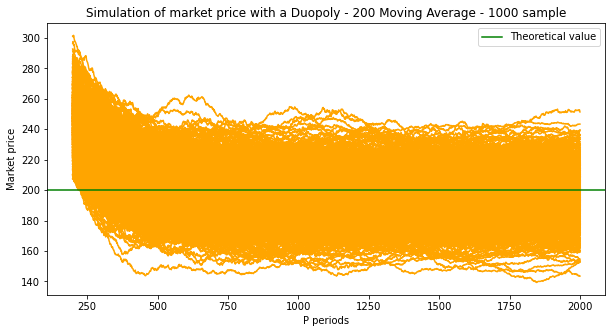

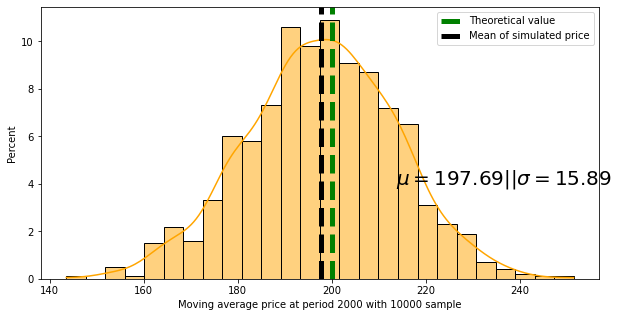

In [211]:
c =plot_multiple(prices,n_firm,n_sample=10000,color="orange")

# Draft
****

In [322]:
def cournot_framework(n_firms, p_periods,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    """Cournot framework
    Args :
        n_firms (int): Number of firms 
        p_periods (int): Number of simulation periods
        initial_propension (float) : initial_propension for each value
        mu (float) : extinction in finite time
        gamma (float) : forget rate 
        delta (flaot) : propension increaser
        total_demand (int): total demand of market
    Returns : 
        bid_mat (np.matrix): Matrix of bid for each firm at each period
        profit_mat (np.matrix): Matrix of profit for each firm at each period
        prop_mat (np.matrix) : Propension matrix for each bid for each firm for each period
        price_vec (np.array) : Market price for each period"""
    s_discrete = int((120/n_firms)//1) #Integer part of 120/n
    bid_mat = np.zeros((p_periods,n_firms)) # Bid matrix
    profit_mat = np.zeros((p_periods,n_firms)) # Profit matrix
    prop_mat = np.ones((s_discrete,n_firms,p_periods))*initial_propension # Propensions matrix
    bid_possibilities = np.arange(1,s_discrete+1)*5
    price_vec = np.zeros(p_periods)
    for period in range(p_periods):
        prob_mat = prop_mat[:,:,period]/sum(prop_mat[:,:,period]) #probability matrix
        for firm in range(n_firms):
            ### Across all firms
            bid_pick = np.random.choice(bid_possibilities,p=prob_mat[:,firm])
            bid_mat[period,firm] = bid_pick
        # Once bid are made we can compute price
        market_price = total_demand-sum(bid_mat[period,:])
        price_vec[period] = market_price
        profit_mat[period,:] = market_price*bid_mat[period,:]
        # Need to recompute propensions for next iterations
        for firm in range(n_firms):
            lambda_ = bid_mat[period,firm]/5
            profit = profit_mat[period,firm]
            for s_bid in range(s_discrete):
                # Part 1 of reinforcement :
                # Current propension for this period
                propension = prop_mat[s_bid,firm,period]
                new_propension = propensions_reinforcement_part1(s_bid,propension,profit,lambda_,delta,gamma)
                # Set propension for next period
                if period + 1 < p_periods:
                    ## Do not outbound
                    prop_mat[s_bid,firm,period+1] = new_propension
            # Second part : adjust regarding mu
            if period + 1 < p_periods:
                ## Do not outbound
                propension_vec = prop_mat[:,firm,period+1]
                propension_vec_mu_filter = (propension_vec/sum(propension_vec))>mu
                prop_mat[:,firm,period+1] = propension_vec*propension_vec_mu_filter
    return (bid_mat,profit_mat,prop_mat,prob_mat,price_vec)